<a href="https://colab.research.google.com/github/High-ren/Classification/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA

We begin by loading the EuroSAT dataset using TensorFlow Datasets (TFDS). This dataset contains over 27,000 labeled images from 10 land cover classes.





In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
dataset, info = tfds.load('eurosat', split='train', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.LSY5WR_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
|X = []
y = []
for image, label in tfds.as_numpy(dataset):
    X.append(image)
    y.append(label)

X = np.array(X)
y = np.array(y)
classes = info.features['label'].names

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from glob import glob
from PIL import Image

In [ ]:
X = X / 255.0  # Normalize pixel values to [0, 1]
y = to_categorical(y, num_classes=len(classes))  # One-hot encode labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (21600, 64, 64, 3)
Testing data shape: (5400, 64, 64, 3)


In [ ]:
# Step 3: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [ ]:
# Step 4: Define Improved CNN Model
def create_improved_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Step 5: Create Model
model = create_improved_model(len(classes))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,276,618 (4.87 MB)

 Trainable params: 1,276,170 (4.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Step 6: Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [ ]:
# Step 7: Train the Model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=5,  # You can adjust this
                    callbacks=callbacks)

Epoch 1/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 252s 373ms/step - accuracy: 0.6892 - loss: 0.9120 - val_accuracy: 0.6863 - val_loss: 1.0876 - learning_rate: 0.0010
Epoch 2/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 250s 370ms/step - accuracy: 0.7246 - loss: 0.8094 - val_accuracy: 0.6437 - val_loss: 1.1509 - learning_rate: 0.0010
Epoch 3/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 253s 375ms/step - accuracy: 0.7422 - loss: 0.7690 - val_accuracy: 0.4843 - val_loss: 2.2400 - learning_rate: 0.0010
Epoch 4/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7667 - loss: 0.7001
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
675/675 ━━━━━━━━━━━━━━━━━━━━ 242s 358ms/step - accuracy: 0.7667 - loss: 0.7001 - val_accuracy: 0.6344 - val_loss: 1.5513 - learning_rate: 0.0010
Epoch 5/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 250s 370ms/step - accuracy: 0.8085 - loss: 0.5831 - val_accuracy: 0.8039 - val_loss: 0.6409 - learning_rate: 5.0000e-04


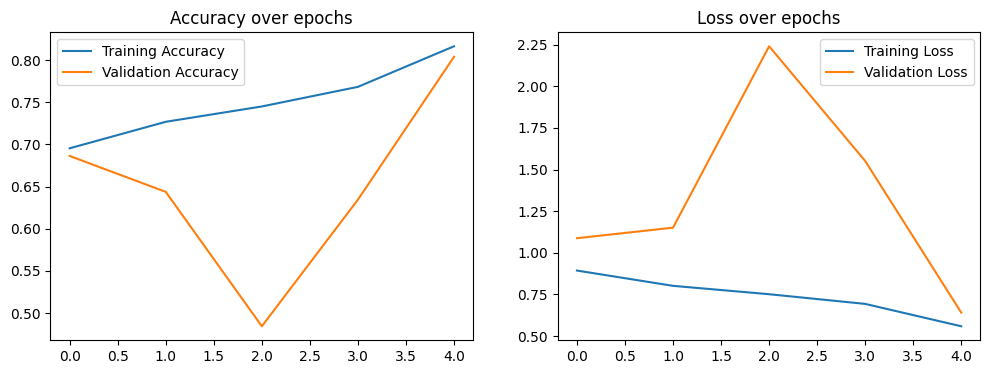

169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step
                      precision    recall  f1-score   support

          AnnualCrop       0.94      0.76      0.84       583
              Forest       0.70      0.98      0.82       598
HerbaceousVegetation       0.86      0.55      0.67       612
             Highway       0.79      0.67      0.73       497
          Industrial       0.97      0.73      0.83       479
             Pasture       0.77      0.84      0.80       389
       PermanentCrop       0.75      0.76      0.75       516
         Residential       0.71      1.00      0.83       592
               River       0.74      0.86      0.79       505
             SeaLake       0.99      0.87      0.93       629

            accuracy                           0.80      5400
           macro avg       0.82      0.80      0.80      5400
        weighted avg       0.83      0.80      0.80      5400



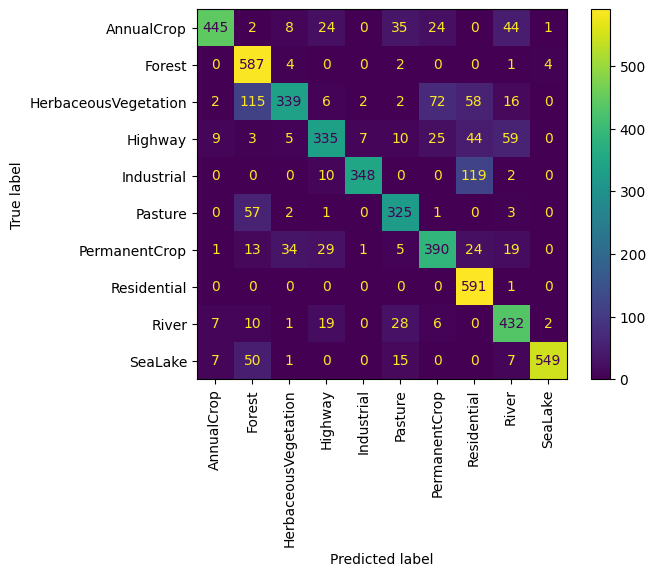

In [ ]:
# Step 8: Evaluate the Model
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.show()

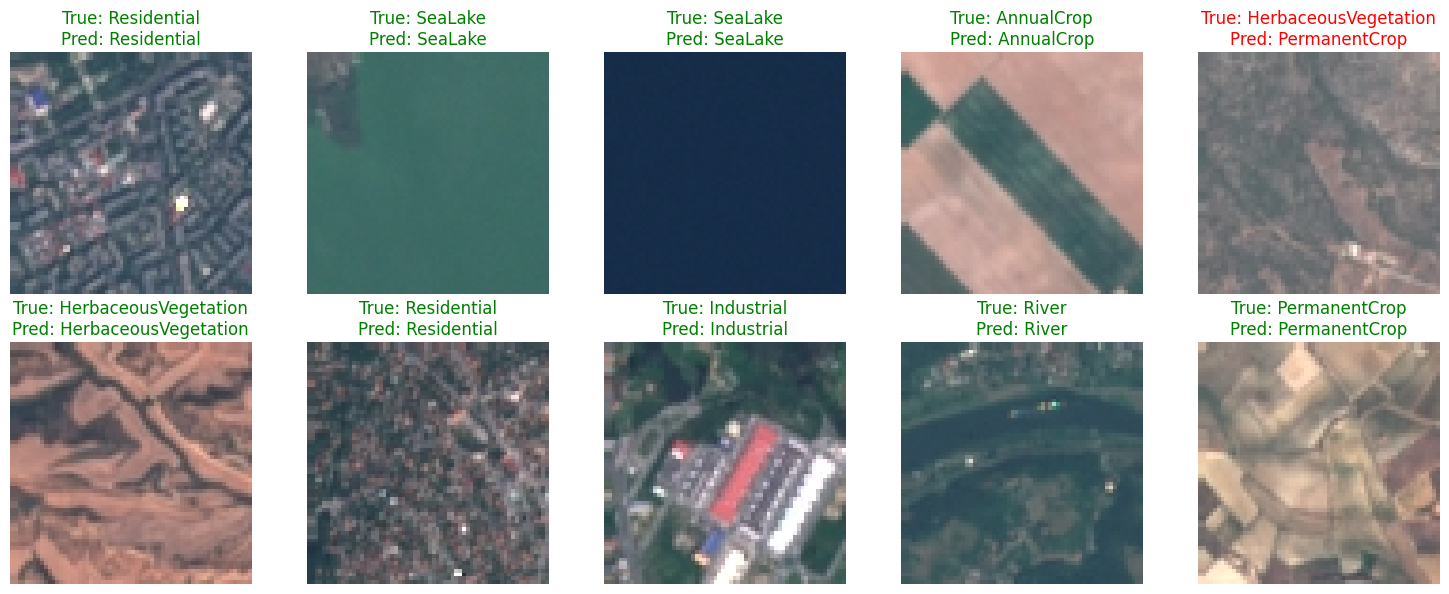

In [ ]:
# Step 9: Visualize predictions on random test images
num_images = 10  # Number of images to display
random_indices = random.sample(range(len(X_test)), num_images)
selected_images = X_test[random_indices]
selected_true_labels = y_true[random_indices]
selected_pred_labels = y_pred[random_indices]

# Plot images with true & predicted labels
plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.axis("off")
    true_label = classes[selected_true_labels[i]]
    pred_label = classes[selected_pred_labels[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()